In [2]:
# if requirements file is updated

# %pip install -r requirements.txt

# if setup file is updated
# pip install .

In [3]:
import torch
from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import re
import numpy as np
import os
from scipy.spatial.distance import pdist, squareform

In [4]:
def get_sentence_embedding(text):
    
    # Tokenize the input text
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    # Pass the input through the BERT model
    output = model(**encoded_input)
    
    # Extract the sentence embedding from the output
    sentence_embedding = output.pooler_output
    
    return sentence_embedding


def get_word_embeddings(text, target_word):
    
    # Tokenize the input text
    tokenized_text = tokenizer.tokenize(text)
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    input_ids = torch.tensor([input_ids])

    # Generate the word embeddings
    output = model(input_ids)[0]  # The first element of the output is the word embeddings
    all_word_embeddings = output[0]
    if target_word in tokenized_text:
            
        # Find the index of the target word
        target_word_index = tokenized_text.index(target_word)

        # Extract the target word embeddings
        target_word_embeddings = all_word_embeddings[target_word_index]
        return all_word_embeddings, target_word_embeddings
    return None, None

# Measure polysemy  of a target word in a text corpus

def measure_polysemy(texts, word):
    '''Currently this function is not correct. 
    It only measures the cosine distance of the different target word embeddings
      in the different sentences where it is found. 
      
    '''  
    embeddings = torch.tensor([])

    for text in texts:
        if word in text:
            _ , target_word_embeddings = get_word_embeddings(text, word)
            sentence_embeddings = get_sentence_embedding(text)
            if target_word_embeddings is not None:
                embeddings = torch.cat((embeddings, target_word_embeddings.unsqueeze(0).detach()), dim=0)
        else:
            pass
    print("Target word embeddings shape is ", embeddings.shape)

    # Measure distances between embeddings

    embeddings_np = embeddings.detach().numpy()
    distances = pdist(embeddings_np, 'cosine')

    return distances

In [5]:
# loading all the text in text data folder
text_sentences = []

for file in os.listdir('../Text data'):
    if file.endswith(".txt"):
        with open(os.path.join('../Text data', file), 'r') as f:
            text = f.read()
            text = re.sub(r'\n', ' ', text)  # Remove newline characters
            text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces

            # Split the textcorpus into a list of sentence strings
            text = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
            text_sentences.extend(text)


In [6]:
# Load the pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# Measure polysemy distances of the target word in the text sentences

target_word = 'by'
texts = text_sentences[0:]
len(texts)

65019

Target word embeddings shape is  torch.Size([2895, 768])
Distances length is  4189065


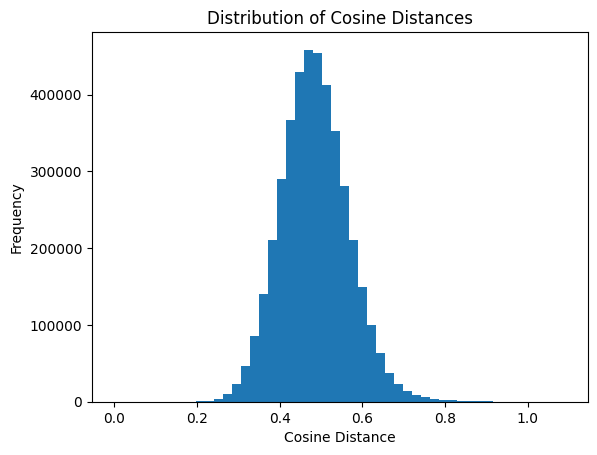

In [8]:
distances = measure_polysemy(texts, target_word)
print('Distances length is ', len(distances))


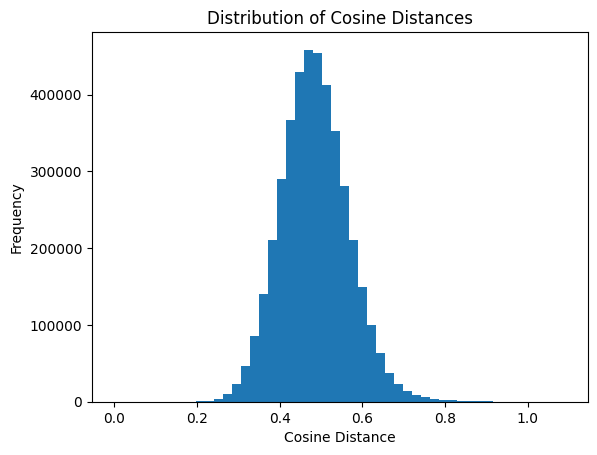

In [9]:
plt.hist(distances, bins=50)
# plt.ylim(0, 100)  # Scale the y axis from 0 to 1000

plt.title("Distribution of Cosine Distances")
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
plt.show()